In [1]:
import os
import shutil
from PIL import Image
import itertools
import imgaug.augmenters as iaa
from pathlib import Path

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization, SeparableConv2D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# used to ignore useless noise warnings
import warnings
warnings.filterwarnings('ignore')

If we want REPRODUCIBLE results:

In [2]:
# If we want to make out results REPRODUCIBLE, we can set the parameters below to increase reproducibility:
# os.environ['PYTHONHASHSEED'] = '0' # Set the seed for hash based operations in python
# np.random.seed(111) # Set the numpy seed
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) # Disable multi-threading in tensorflow ops
# tf.compat.v1.set_random_seed(111) # Set the random seed in tensorflow at graph level
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf) # Define a tensorflow session with the session configs set above
# K.set_session(sess) # Set the session in keras
# aug.seed(111) # Make the augmentation sequence deterministic

## Preprocessing
Creating train, test and validation labeled dataframes:

In [2]:
# The function generates a labeled paths dataset using the subfolder names of a given directory as names.
# First column is file paths, second column is file labels.
def createDataframe(data_path):
    filePaths = []
    fileLabels = []

    pathDirs = os.listdir(data_path)
    for subfolder in pathDirs:
        subfolderPath = os.path.join(data_path, subfolder)
        filesList = os.listdir(subfolderPath)
        
        for file in filesList:
            filePath = os.path.join(subfolderPath, file)
            filePaths.append(filePath)
            fileLabels.append(subfolder)
            
    fileSeries = pd.Series(filePaths, name='filepath')
    labelSeries = pd.Series(fileLabels, name='label')

    dataframe = pd.concat([fileSeries, labelSeries], axis=1)
    return dataframe


trainDataPath = 'input/chest_xray/train'
validationDataPath = 'input/chest_xray/val'
testDataPath = 'input/chest_xray/test'

trainDataframe = createDataframe(trainDataPath)
validationDataframe = createDataframe(validationDataPath)
testDataframe = createDataframe(testDataPath)

def whatsInDatDataframes(*dataframes):
    for dataframe, dataframe_name in dataframes:
        total_files = len(dataframe)
        labels = dataframe['label'].unique()
        
        print(f'Number of files in {dataframe_name} dataframe:', total_files)
        for label in labels:
            num_files = len(dataframe[dataframe['label'] == label])
            print(f"- {label}: {num_files}")

whatsInDatDataframes([trainDataframe, 'train'], [validationDataframe, 'validation'], [testDataframe, 'test'])


Number of files in train dataframe: 5216
- NORMAL: 1341
- PNEUMONIA: 3875
Number of files in validation dataframe: 16
- NORMAL: 8
- PNEUMONIA: 8
Number of files in test dataframe: 624
- NORMAL: 234
- PNEUMONIA: 390


In [3]:
# I will not use the original division of the dataset and will create my own:
# trainDataframe, dummy_df = train_test_split(trainDataframe, train_size=0.8, shuffle=True, random_state=42)
# validationDataframe, testDataframe = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

In [4]:
trainDataframe.head()

,filepath,label
927,input/chest_xray/train\NORMAL\NORMAL2-IM-0868-...,NORMAL
2499,input/chest_xray/train\PNEUMONIA\person152_vir...,PNEUMONIA
45,input/chest_xray/train\NORMAL\IM-0205-0001.jpeg,NORMAL
1741,input/chest_xray/train\PNEUMONIA\person1211_vi...,PNEUMONIA
2275,input/chest_xray/train\PNEUMONIA\person1445_ba...,PNEUMONIA


Insted of manulal generator creation, we will use ImageDataGenerator():

In [5]:
batch_size = 16
img_size = (224, 224)

train_gen = ImageDataGenerator().flow_from_dataframe(   # return [batch of pictures] and [labels]
    trainDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ImageDataGenerator().flow_from_dataframe(
    validationDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',shuffle=True,
    batch_size=batch_size
)

test_gen = ImageDataGenerator().flow_from_dataframe(
    testDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


## Dataset check

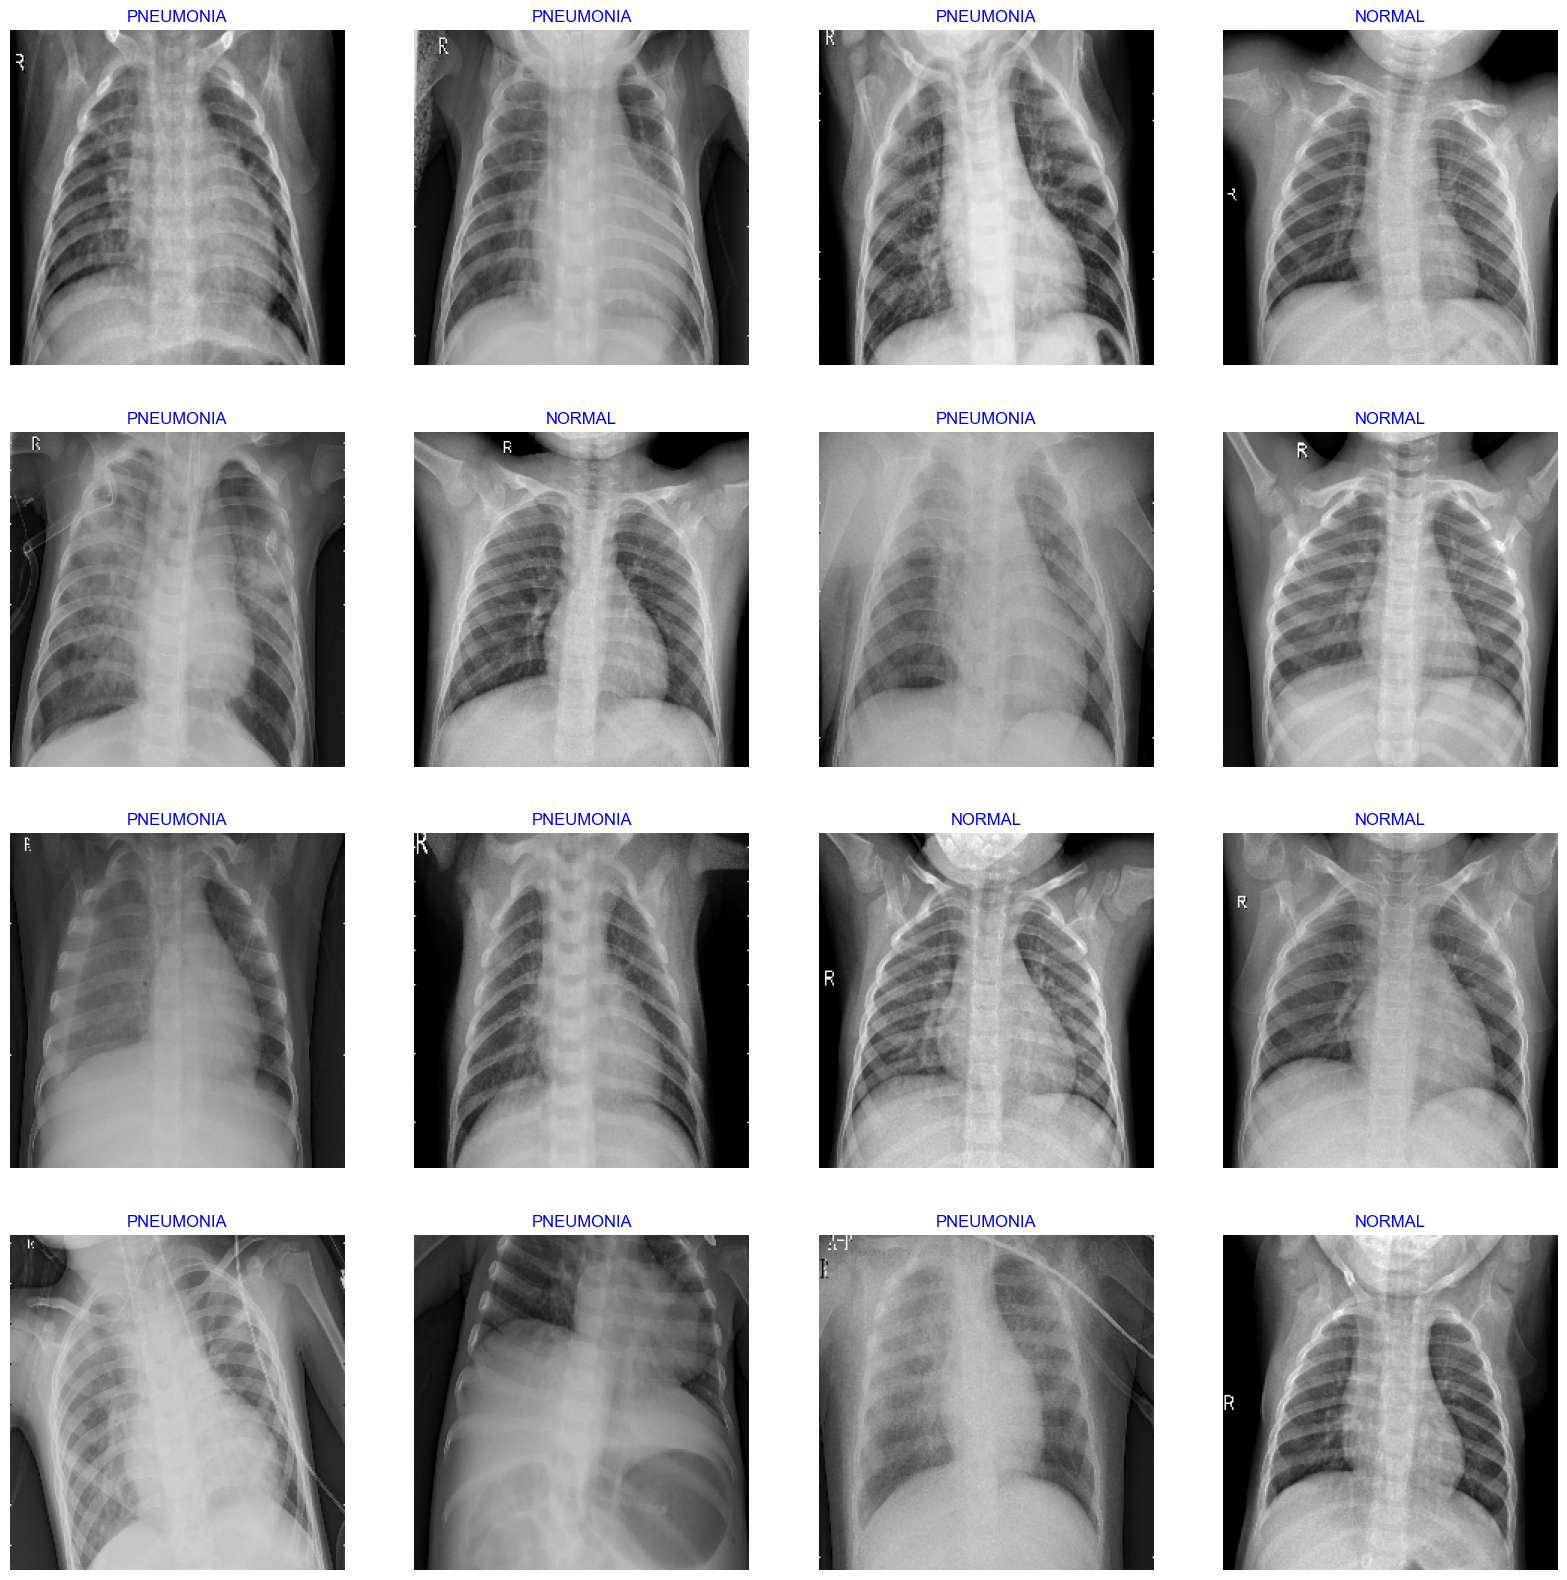

In [6]:
gen_dict = train_gen.class_indices      # {'NORMAL': 0, 'PNEUMONIA': 1}
classes = list(gen_dict.keys())         # ['NORMAL', 'PNEUMONIA']
images , fileLabels = next(train_gen)   # return [batch of pictures] and [labels]

plt.figure(figsize= (20,20))
for i in range(batch_size):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(fileLabels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

# MODEL 1
Default CNN architecture.

## Model Structure

First model is one of default simple CNN structures:

In [7]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

## Model Training

In [50]:
epochs = 6   # number of all epochs in training

history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/6
261/261 [==============================] - 104s 391ms/step - loss: 2.7050 - accuracy: 0.7987 - val_loss: 0.2952 - val_accuracy: 0.8774
Epoch 2/6
261/261 [==============================] - 83s 318ms/step - loss: 0.2565 - accuracy: 0.8869 - val_loss: 0.2221 - val_accuracy: 0.9138
Epoch 3/6
261/261 [==============================] - 85s 324ms/step - loss: 0.1985 - accuracy: 0.9154 - val_loss: 0.2956 - val_accuracy: 0.8640
Epoch 4/6
261/261 [==============================] - 85s 326ms/step - loss: 0.1843 - accuracy: 0.9231 - val_loss: 0.1950 - val_accuracy: 0.9425
Epoch 5/6
261/261 [==============================] - 84s 321ms/step - loss: 0.1633 - accuracy: 0.9322 - val_loss: 0.1259 - val_accuracy: 0.9521
Epoch 6/6
261/261 [==============================] - 84s 320ms/step - loss: 0.1394 - accuracy: 0.9410 - val_loss: 0.1553 - val_accuracy: 0.9579


## Model Evaluation

In [8]:
def modelGraphs(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

def modelEvaluationMetrix(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)

    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

def modelConfustionMatrix(model, testGenrator):
    preds = model.predict_generator(testGenrator)
    y_pred = np.argmax(preds, axis=1) 

    g_dict = testGenrator.class_indices
    classes = list(g_dict.keys())

    # Confusion matrix
    cm = confusion_matrix(testGenrator.classes, y_pred)
    cm

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def modelClassificationReport(model, testGenrator):

    preds = model.predict_generator(testGenrator)
    y_pred = np.argmax(preds, axis=1)

    g_dict = testGenrator.class_indices
    classes = list(g_dict.keys())
    
    print(classification_report(testGenrator.classes, y_pred, target_names=classes))

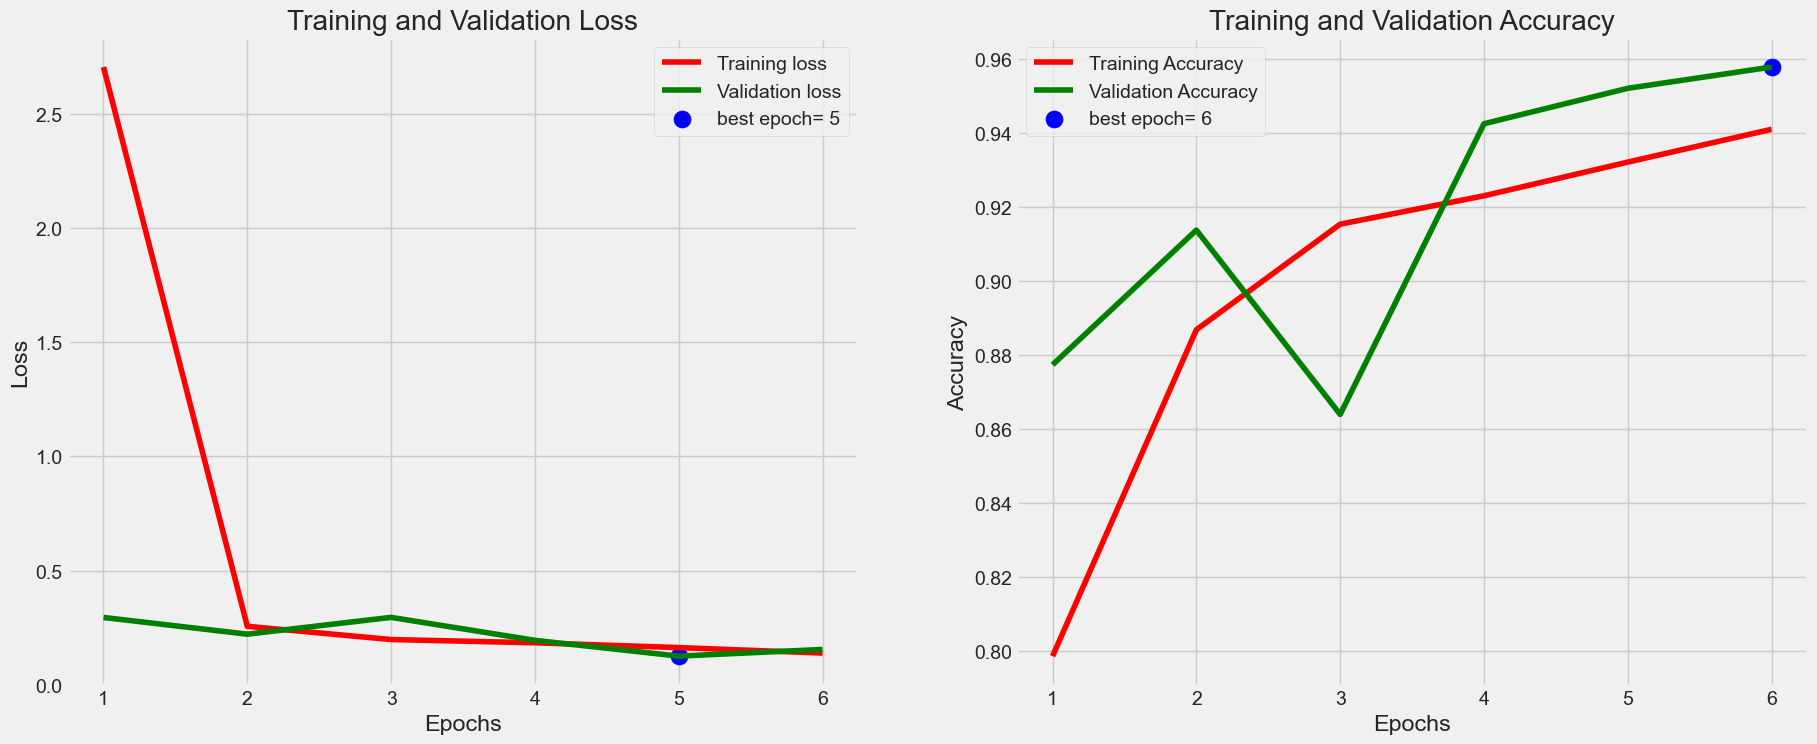

33/33 [==============================] - 5s 157ms/step - loss: 0.1856 - accuracy: 0.9253
Train Loss:  0.10725852102041245
Train Accuracy:  0.9590124487876892
--------------------
Validation Loss:  0.1552770882844925
Validation Accuracy:  0.9578543901443481
--------------------
Test Loss:  0.18562714755535126
Test Accuracy:  0.9252873659133911


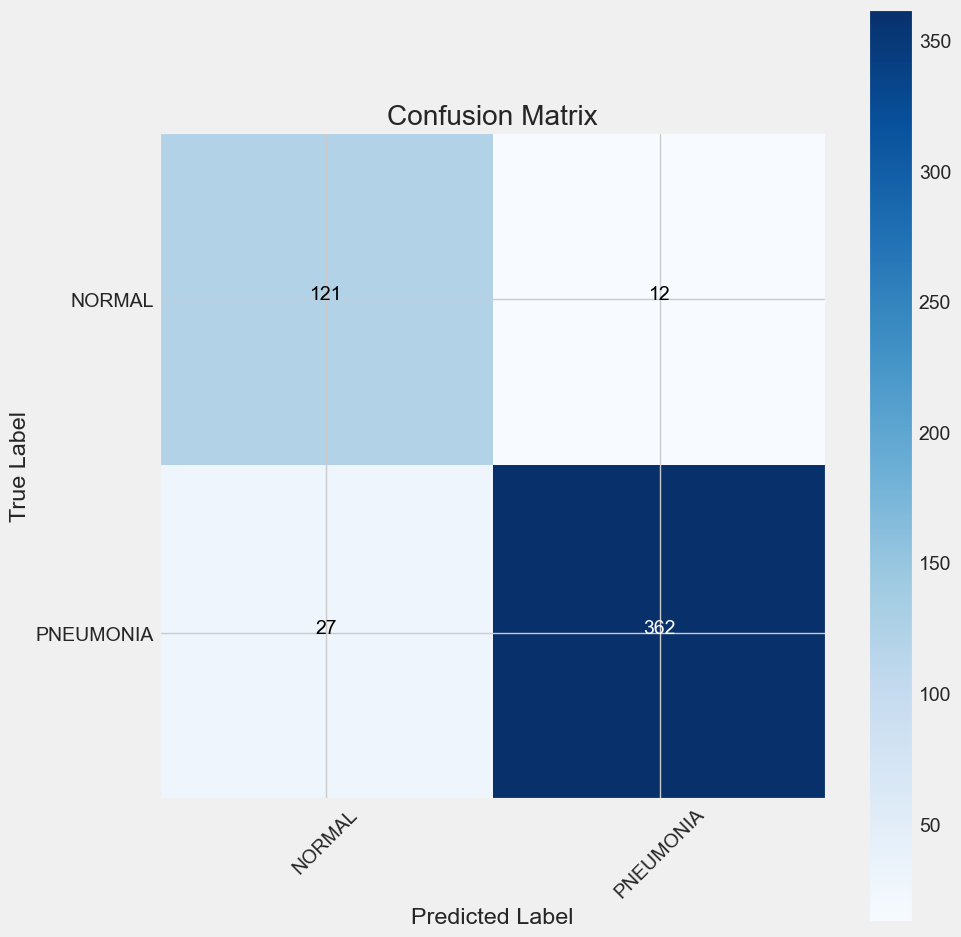

              precision    recall  f1-score   support

      NORMAL       0.82      0.91      0.86       133
   PNEUMONIA       0.97      0.93      0.95       389

    accuracy                           0.93       522
   macro avg       0.89      0.92      0.91       522
weighted avg       0.93      0.93      0.93       522



In [51]:
modelGraphs(history)
modelEvaluationMetrix(model)
modelConfustionMatrix(model, test_gen)
modelClassificationReport(model, test_gen)

In [53]:
# this is in case if previous model was better, короче удалить нахуй эту модель, если предыдущая лучше
# а дальше всё будет трениться на 15 эпохов всё йопта я спать

epochs = 15   # number of all epochs in training
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/15
261/261 [==============================] - 85s 323ms/step - loss: 0.0592 - accuracy: 0.9765 - val_loss: 0.1002 - val_accuracy: 0.9732
Epoch 2/15
261/261 [==============================] - 85s 324ms/step - loss: 0.0484 - accuracy: 0.9808 - val_loss: 0.0492 - val_accuracy: 0.9847
Epoch 3/15
261/261 [==============================] - 85s 325ms/step - loss: 0.0402 - accuracy: 0.9851 - val_loss: 0.0755 - val_accuracy: 0.9751
Epoch 4/15
261/261 [==============================] - 86s 327ms/step - loss: 0.0333 - accuracy: 0.9873 - val_loss: 0.0590 - val_accuracy: 0.9808
Epoch 5/15
261/261 [==============================] - 85s 327ms/step - loss: 0.0322 - accuracy: 0.9878 - val_loss: 0.0732 - val_accuracy: 0.9789
Epoch 6/15
261/261 [==============================] - 86s 329ms/step - loss: 0.0156 - accuracy: 0.9942 - val_loss: 0.0821 - val_accuracy: 0.9847
Epoch 7/15
261/261 [==============================] - 119s 454ms/step - loss: 0.0205 - accuracy: 0.9928 - val_loss: 0.0543 - val_a

# MODEL 2
Let's change the model structure to the more elaborated one that was used in the previous file.

## Model Structure

In [9]:
model2 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape, name='Conv1_1'),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_2'),
    MaxPooling2D((2, 2), name='pool1'),

    SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1'),
    SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2'),
    MaxPooling2D((2,2), name='pool2'),


    SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1'),
    BatchNormalization(name='bn1'),
    SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2'),
    BatchNormalization(name='bn2'),
    SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3'),
    MaxPooling2D((2,2), name='pool3'),

    SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1'),
    BatchNormalization(name='bn3'),
    SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2'),
    BatchNormalization(name='bn4'),
    SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3'),
    MaxPooling2D((2,2), name='pool4'),
    
    Flatten(name='flatten'),

    Dense(1024, activation='relu', name='fc1'),
    Dropout(0.7, name='dropout1'),
    Dense(512, activation='relu', name='fc2'),
    Dropout(0.5, name='dropout2'),
    Dense(class_count, activation='softmax', name='fc3'),
])

model2.compile(Adamax(learning_rate= 0.001), loss='categorical_crossentropy', metrics= ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
Conv3_1 (SeparableConv2D)    (None, 56, 56, 256)      

## Model Training

In [2]:

# This may help with Exhaust Memory Erro issue
# Setting GPU options
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Creating a TensorFlow session
session = tf.compat.v1.InteractiveSession()


In [12]:
epochs=15
history2 = model2.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle= False)

Epoch 1/15
261/261 [==============================] - 122s 430ms/step - loss: 0.2496 - accuracy: 0.8897 - val_loss: 0.6126 - val_accuracy: 0.7050
Epoch 2/15
261/261 [==============================] - 121s 463ms/step - loss: 0.1203 - accuracy: 0.9535 - val_loss: 0.9293 - val_accuracy: 0.7050
Epoch 3/15
261/261 [==============================] - 120s 461ms/step - loss: 0.0895 - accuracy: 0.9662 - val_loss: 0.1211 - val_accuracy: 0.9540
Epoch 4/15
261/261 [==============================] - 120s 460ms/step - loss: 0.0643 - accuracy: 0.9784 - val_loss: 0.1053 - val_accuracy: 0.9674
Epoch 5/15
261/261 [==============================] - 121s 463ms/step - loss: 0.0535 - accuracy: 0.9777 - val_loss: 0.0972 - val_accuracy: 0.9617
Epoch 6/15
261/261 [==============================] - 143s 547ms/step - loss: 0.0421 - accuracy: 0.9842 - val_loss: 0.0914 - val_accuracy: 0.9693
Epoch 7/15
261/261 [==============================] - 170s 651ms/step - loss: 0.0328 - accuracy: 0.9871 - val_loss: 0.0629 -

## Model Evaluation

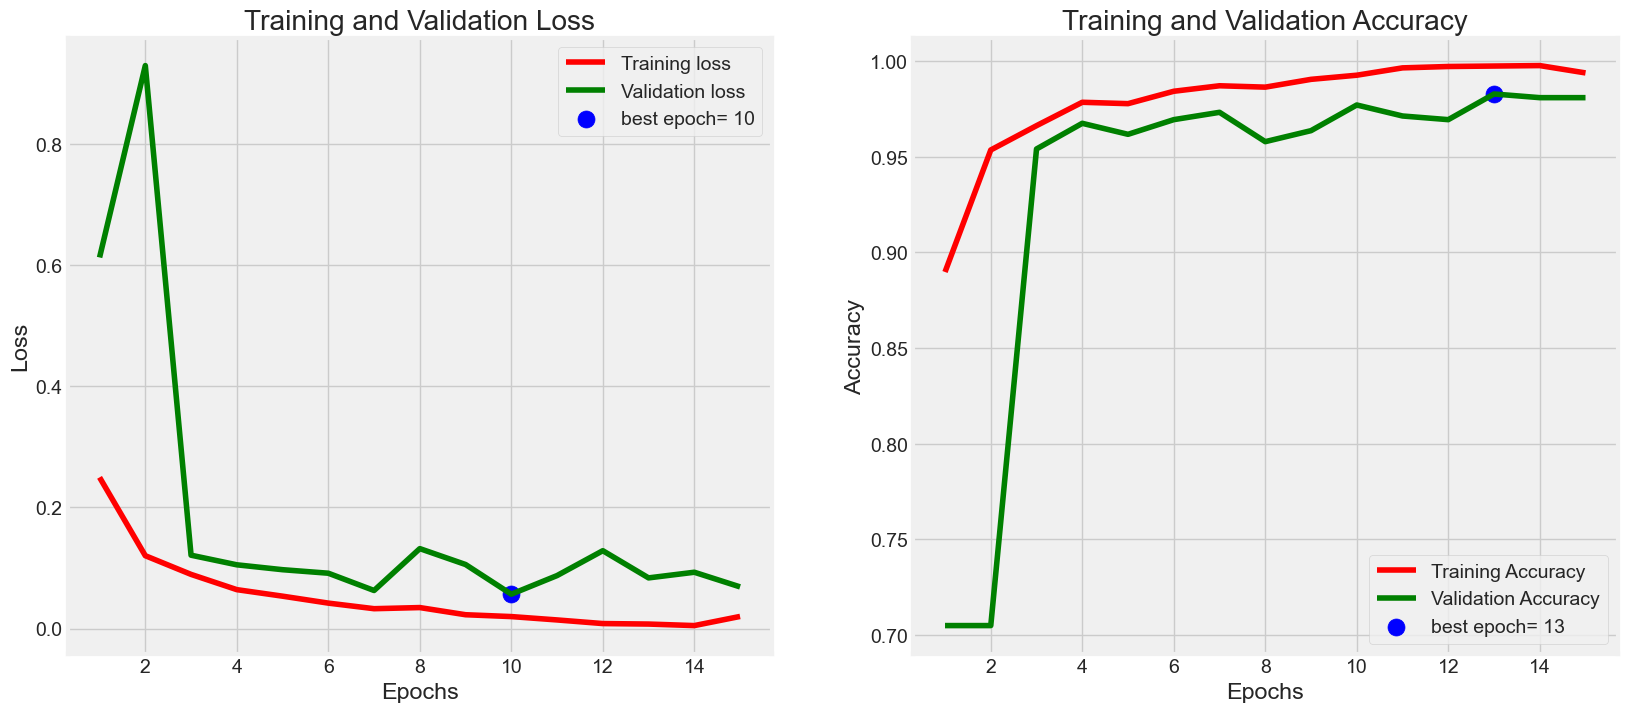

33/33 [==============================] - 5s 150ms/step - loss: 0.0702 - accuracy: 0.9828
Train Loss:  0.000925479456782341
Train Accuracy:  0.9997603297233582
--------------------
Validation Loss:  0.06884369254112244
Validation Accuracy:  0.9808428883552551
--------------------
Test Loss:  0.07021006941795349
Test Accuracy:  0.982758641242981


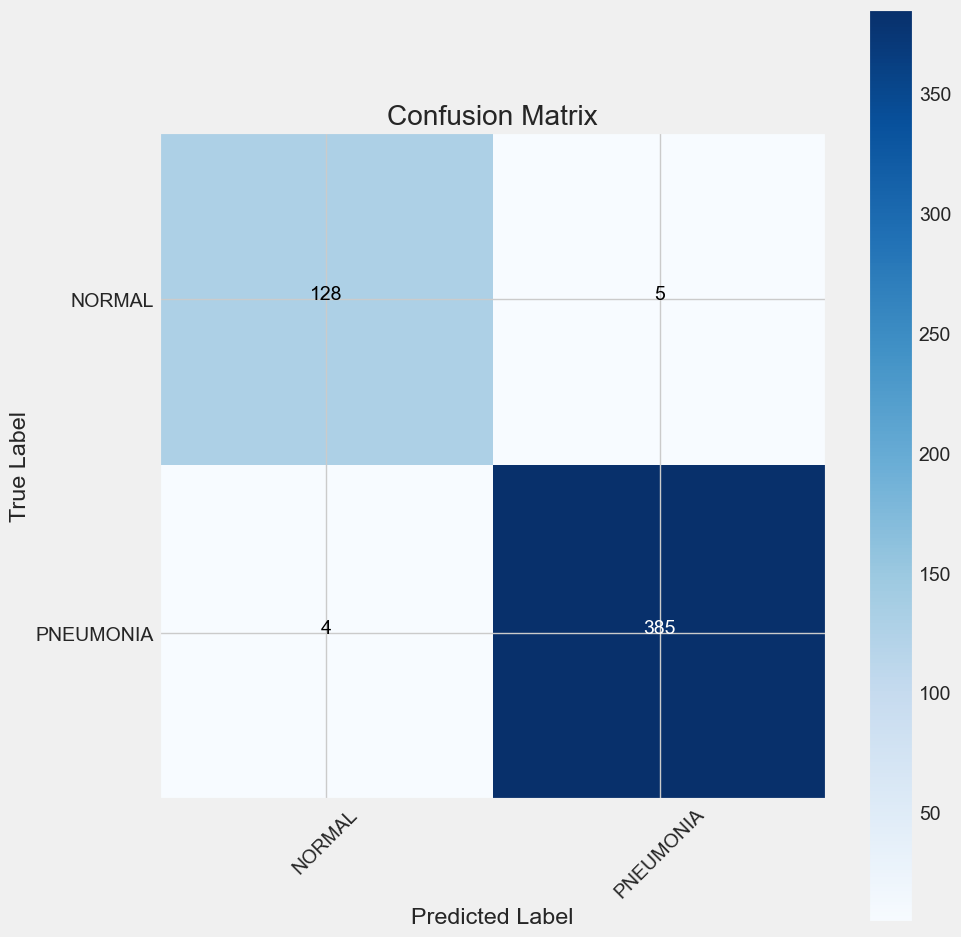

              precision    recall  f1-score   support

      NORMAL       0.97      0.96      0.97       133
   PNEUMONIA       0.99      0.99      0.99       389

    accuracy                           0.98       522
   macro avg       0.98      0.98      0.98       522
weighted avg       0.98      0.98      0.98       522



In [13]:
modelGraphs(history2)
modelEvaluationMetrix(model2)
modelConfustionMatrix(model2, test_gen)
modelClassificationReport(model2, test_gen)

# DATA AUGMENTATION
As we see, our train dataset is **highly imbalanced**. To solve this issue and increase the model's perdomance, let's balance the datasets using general augmentation methods. We will be using imgaug library for this purpose.

Also, some of the files are 1-channelled and we want to turn them into 3 channels.

TF default ImageDataGenerator() augmentation has very poor number of features and does not allow to work with channels. We should either create out own generator or manually create another dataset. I use the second approach because I can easily check if the algorithm works.

FIRST step is to make copy of both folders and process the pictures with general reshaping and channel set.

In [14]:
trainSourcePathNormalLabel = "input/chest_xray/train/NORMAL"
trainSourcePathPneumoniaLabel = "input/chest_xray/train/PNEUMONIA"
destinationPathNormalLabel = "input/chest_xray/train_augmented/NORMAL"
destinationPneumonia = "input/chest_xray/train_augmented/PNEUMONIA"

# The function makes a copy of pictures from one folder to another.
# Also resizes the pictures and sets the correct number of channels for greyscale ones.
def copyAndPrepare(sourcePath, destinationPath):
    os.makedirs(destinationPath, exist_ok=True)

    for imageName in os.listdir(sourcePath):
        imagePath = os.path.join(sourcePath, imageName)
        img = cv2.imread(str(imagePath))
        img = cv2.resize(img, (224,224))
        # check if it's grayscale
        if img.shape[2]==1:
            img = np.dstack([img, img, img])
        # cv2 reads in BGR mode by default, so we need to convert it
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Save the processed image
        filename = Path(imagePath).stem + '_processed.jpeg'  # Assuming you want to save as JPG
        save_path = Path(destinationPath) / filename  # Change 'input/chest_xray/train_augmented/' to your desired directory
        cv2.imwrite(str(save_path), img)

    print("Files from folder,", sourcePath, " copied successfully to folder ", destinationPath)

copyAndPrepare(trainSourcePathNormalLabel, destinationPathNormalLabel)
copyAndPrepare(trainSourcePathPneumoniaLabel, destinationPneumonia)

# Shows the number of files in folders:
def whatsInDatFolders(*folders):
    for folder_path in folders:
        total_files = 0
        # print(f"Folder: {folder_path}")
        for root, dirs, files in os.walk(folder_path):
            num_files = len(files)
            total_files += num_files
            folder_label = os.path.basename(root)
            print(f"- {folder_label}: {num_files} files")
        print(f"Total files in {folder_path}: {total_files}\n")

# Let's compare the original number of files and the number of copied ones:
whatsInDatFolders('input/chest_xray/train')
whatsInDatFolders('input/chest_xray/train_augmented')

Files from folder, input/chest_xray/train/NORMAL  copied successfully to folder  input/chest_xray/train_augmented/NORMAL
Files from folder, input/chest_xray/train/PNEUMONIA  copied successfully to folder  input/chest_xray/train_augmented/PNEUMONIA
- train: 0 files
- NORMAL: 1341 files
- PNEUMONIA: 3875 files
Total files in input/chest_xray/train: 5216

- train_augmented: 0 files
- NORMAL: 1341 files
- PNEUMONIA: 3875 files
Total files in input/chest_xray/train_augmented: 5216



SECOND step is the augmentation itself:

In [15]:
# I will be using the function to create the aug files and the augmentation sequence described right after it.

# The function creates a defined number of new pictures from inputPath and save in to outputPath
# using the specified augmentationSequence.
def createAugmentedFiles(numberOfNewFiles, inputPath, outputPath, augmentationSequence):
    # Get the list of original image files
    original_files = os.listdir(inputPath)
    original_files = [file for file in original_files if file.endswith('.jpeg')]

    os.makedirs(outputPath, exist_ok=True)

    counter = 0
    # Randomly choose original files and augment them
    for _ in range(numberOfNewFiles):
        # Choose a random original file
        original_file = np.random.choice(original_files)
        # Load the image
        image = cv2.imread(os.path.join(inputPath, original_file))
        # Apply augmentation
        augmented_image = augmentationSequence(image=image)
        # Generate a new file name
        new_file_name = os.path.splitext(original_file)[0] + "_augmented_" + str(_) + ".jpeg"
        # Save the augmented image
        cv2.imwrite(os.path.join(outputPath, new_file_name), augmented_image)
        counter = counter + 1

    print("Augmentation completed. {counter} augmented files added.\nSource folder: {inputPath}\nOutput folder: {outputPath}")

seq = iaa.OneOf([               # it takes randomly one of the techniques below:
    iaa.Fliplr(),               # horizontal flips
    iaa.Affine(rotate=20),      # rotation
    iaa.Multiply((1.2, 1.5))    # random brightness
])

input_folder = "input/chest_xray/train/NORMAL"
output_folder = "input/chest_xray/train_augmented/NORMAL"

# Define the number of additional files to create:
additionalFilesNeeded = len(os.listdir(trainSourcePathPneumoniaLabel)) - len(os.listdir(trainSourcePathNormalLabel))
createAugmentedFiles(additionalFilesNeeded, input_folder, output_folder, seq)

# Let's compare the original number of files and the number of copied ones:
whatsInDatFolders('input/chest_xray/train')
whatsInDatFolders('input/chest_xray/train_augmented')

Augmentation completed. {counter} augmented files added.
Source folder: {inputPath}
Output folder: {outputPath}
- train: 0 files
- NORMAL: 1341 files
- PNEUMONIA: 3875 files
Total files in input/chest_xray/train: 5216

- train_augmented: 0 files
- NORMAL: 3875 files
- PNEUMONIA: 3875 files
Total files in input/chest_xray/train_augmented: 7750



# MODEL 1 AND MODEL 2 AFTER THE AUGMENTATION

Updating train dataFrame:

In [12]:
trainDataPath = 'input/chest_xray/train_augmented'
trainDataframe = createDataframe(trainDataPath)

# Checking once again what's in the dataFrames:
whatsInDatDataframes([trainDataframe, 'train'], [validationDataframe, 'validation'], [testDataframe, 'test'])


Number of files in train dataframe: 7750
- NORMAL: 3875
- PNEUMONIA: 3875
Number of files in validation dataframe: 522
- PNEUMONIA: 368
- NORMAL: 154
Number of files in test dataframe: 522
- PNEUMONIA: 389
- NORMAL: 133


In [13]:
trainDataframe, dummy_df = train_test_split(trainDataframe, train_size=0.8, shuffle=True, random_state=42)
validationDataframe, testDataframe = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

train_gen = ImageDataGenerator().flow_from_dataframe(
    trainDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ImageDataGenerator().flow_from_dataframe(
    validationDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',shuffle=True,
    batch_size=batch_size
)

test_gen = ImageDataGenerator().flow_from_dataframe(
    testDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 6200 validated image filenames belonging to 2 classes.
Found 775 validated image filenames belonging to 2 classes.
Found 775 validated image filenames belonging to 2 classes.


In [18]:
history3 = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle= False)

Epoch 1/15
388/388 [==============================] - 264s 651ms/step - loss: 4.0954 - accuracy: 0.8373 - val_loss: 0.1954 - val_accuracy: 0.9161
Epoch 2/15
388/388 [==============================] - 243s 625ms/step - loss: 0.1212 - accuracy: 0.9527 - val_loss: 0.1175 - val_accuracy: 0.9665
Epoch 3/15
388/388 [==============================] - 242s 624ms/step - loss: 0.0791 - accuracy: 0.9700 - val_loss: 0.0542 - val_accuracy: 0.9806
Epoch 4/15
388/388 [==============================] - 241s 621ms/step - loss: 0.0581 - accuracy: 0.9795 - val_loss: 0.0541 - val_accuracy: 0.9794
Epoch 5/15
388/388 [==============================] - 243s 625ms/step - loss: 0.0537 - accuracy: 0.9781 - val_loss: 0.0657 - val_accuracy: 0.9703
Epoch 6/15
388/388 [==============================] - 244s 628ms/step - loss: 0.0379 - accuracy: 0.9873 - val_loss: 0.0467 - val_accuracy: 0.9871
Epoch 7/15
388/388 [==============================] - 244s 628ms/step - loss: 0.0387 - accuracy: 0.9882 - val_loss: 0.0530 -

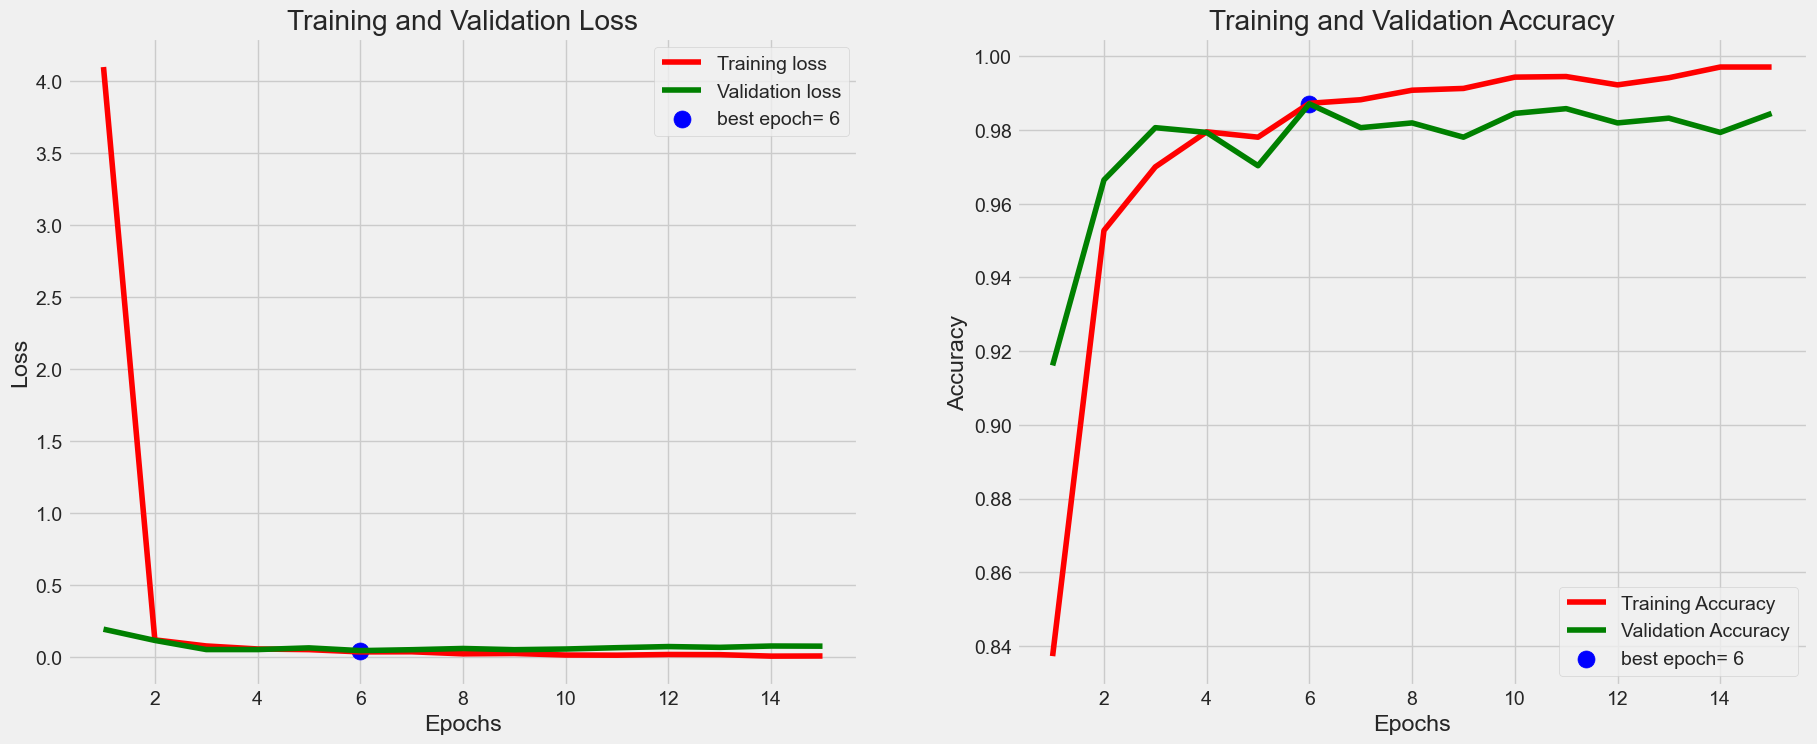

49/49 [==============================] - 10s 194ms/step - loss: 0.0708 - accuracy: 0.9884
Train Loss:  0.004816705826669931
Train Accuracy:  0.9982258081436157
--------------------
Validation Loss:  0.07763947546482086
Validation Accuracy:  0.9845161437988281
--------------------
Test Loss:  0.07078490406274796
Test Accuracy:  0.9883871078491211


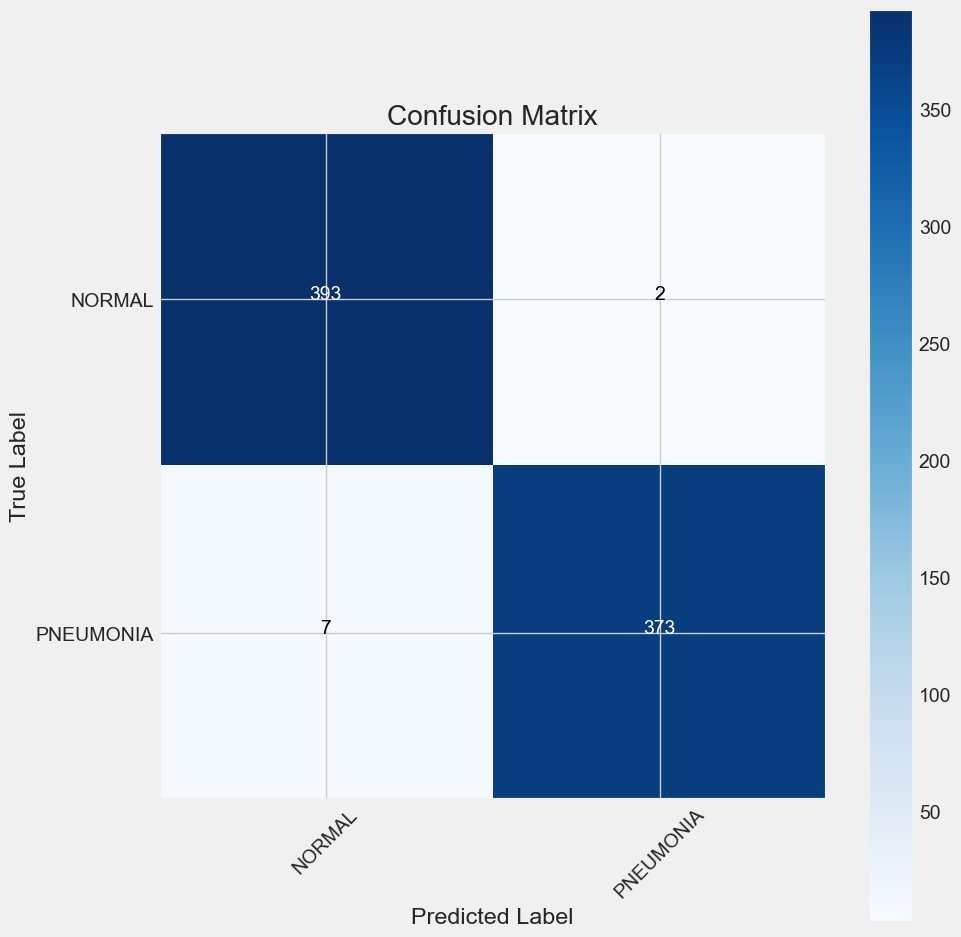

              precision    recall  f1-score   support

      NORMAL       0.98      0.99      0.99       395
   PNEUMONIA       0.99      0.98      0.99       380

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775



In [19]:
modelGraphs(history3)
modelEvaluationMetrix(model)
modelConfustionMatrix(model, test_gen)
modelClassificationReport(model, test_gen)

In [20]:
history4 = model2.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle= False)

Epoch 1/15
388/388 [==============================] - 245s 632ms/step - loss: 0.0396 - accuracy: 0.9879 - val_loss: 0.0357 - val_accuracy: 0.9858
Epoch 2/15
388/388 [==============================] - 241s 620ms/step - loss: 0.0196 - accuracy: 0.9927 - val_loss: 0.0240 - val_accuracy: 0.9910
Epoch 3/15
388/388 [==============================] - 240s 619ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0313 - val_accuracy: 0.9923
Epoch 4/15
388/388 [==============================] - 241s 621ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0165 - val_accuracy: 0.9961
Epoch 5/15
388/388 [==============================] - 241s 620ms/step - loss: 0.0059 - accuracy: 0.9977 - val_loss: 0.0199 - val_accuracy: 0.9910
Epoch 6/15
388/388 [==============================] - 241s 620ms/step - loss: 0.0091 - accuracy: 0.9966 - val_loss: 0.0102 - val_accuracy: 0.9961
Epoch 7/15
388/388 [==============================] - 241s 621ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0345 -

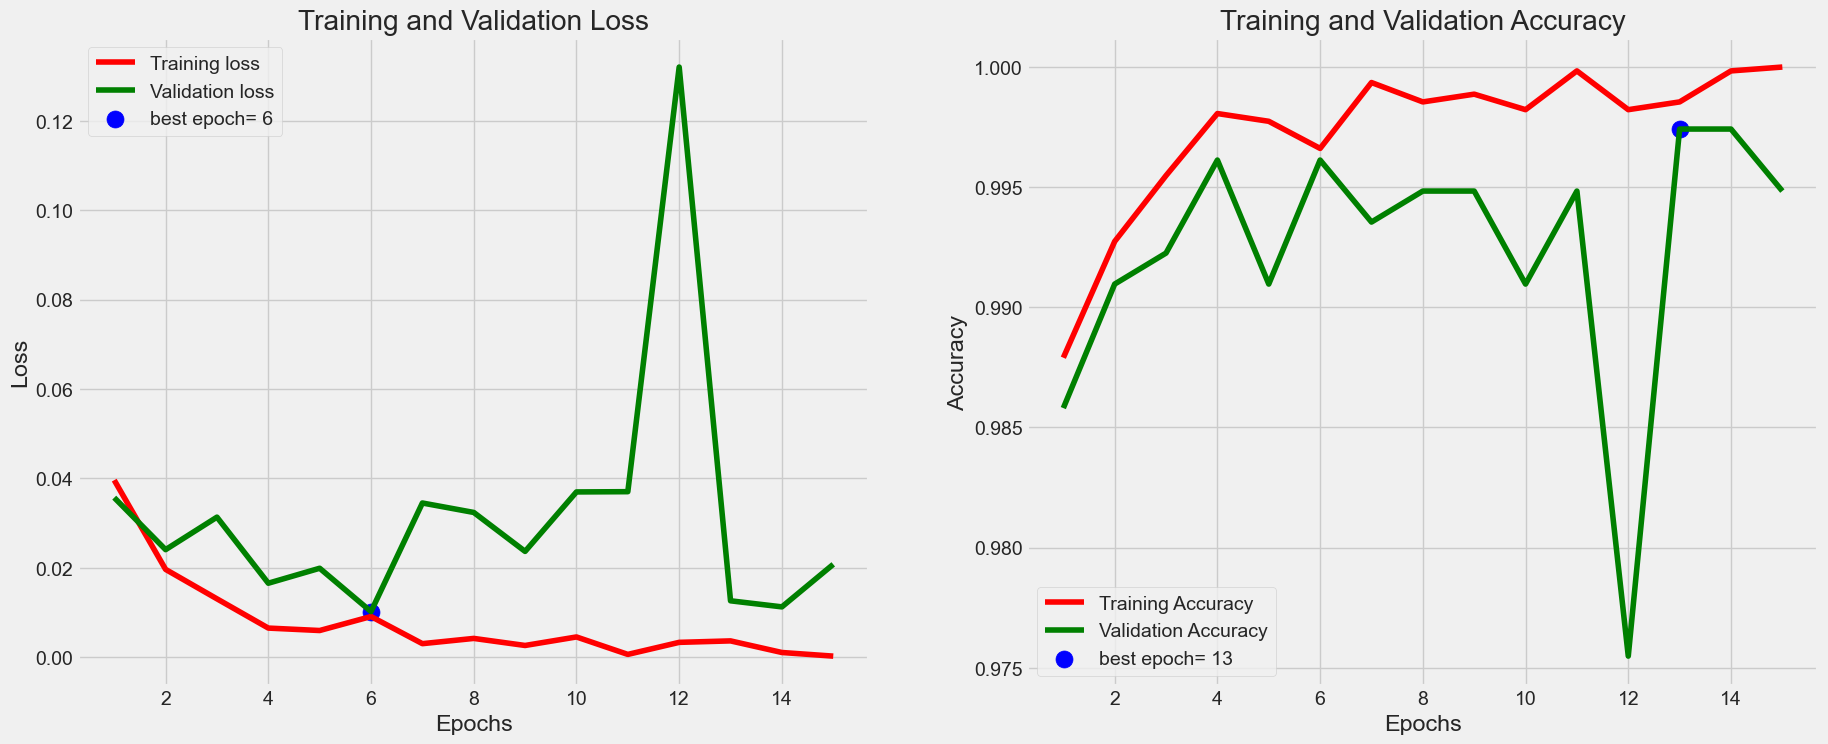

49/49 [==============================] - 6s 117ms/step - loss: 0.0260 - accuracy: 0.9948
Train Loss:  2.6178910047747195e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.020737236365675926
Validation Accuracy:  0.9948387145996094
--------------------
Test Loss:  0.02604924887418747
Test Accuracy:  0.9948387145996094


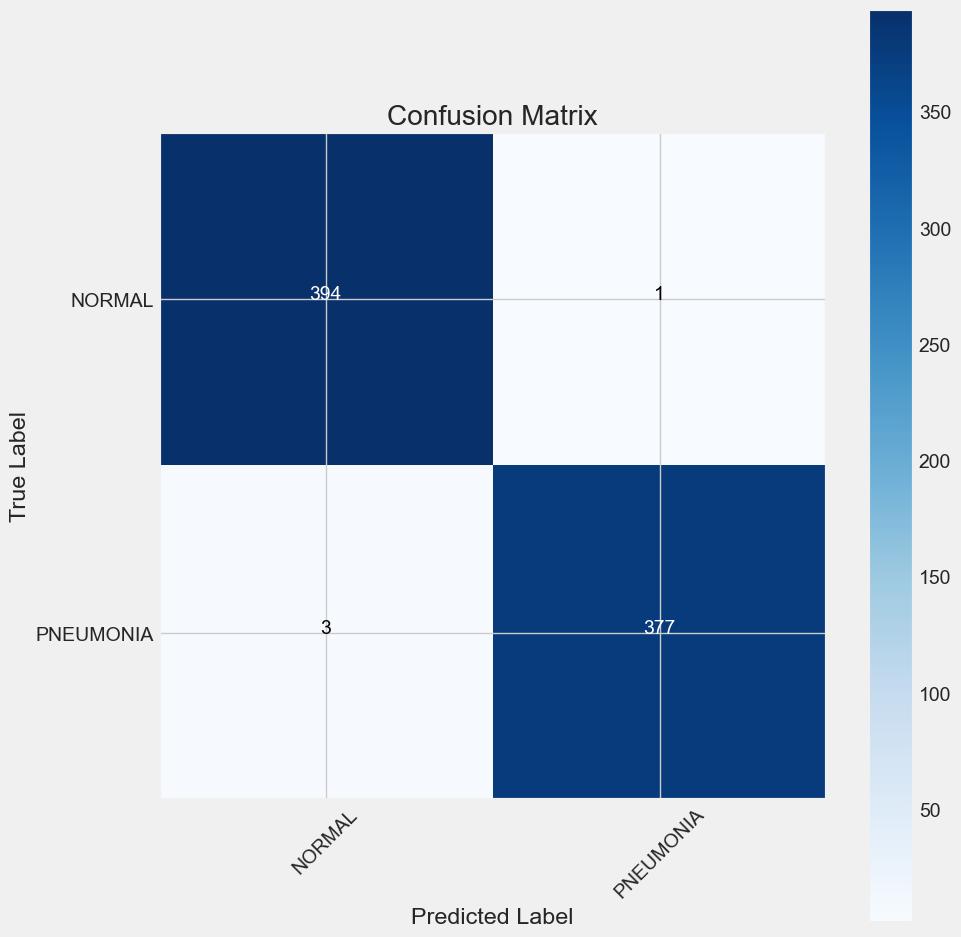

              precision    recall  f1-score   support

      NORMAL       0.99      1.00      0.99       395
   PNEUMONIA       1.00      0.99      0.99       380

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775



In [21]:
modelGraphs(history4)
modelEvaluationMetrix(model2)
modelConfustionMatrix(model2, test_gen)
modelClassificationReport(model2, test_gen)

In [22]:
#train_df, dummy_df = train_test_split(trainDataframe, train_size=0.8, shuffle=True, random_state=42)
#valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)
# train_df, dummy_df = train_test_split(trainDataframe, train_size=0.8, shuffle=True, random_state=42)
# valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)
# # crobed image size
# batch_size = 16
# img_size = (224, 224)

# tr_gen = ImageDataGenerator()
# ts_gen = ImageDataGenerator()
# val_gen= ImageDataGenerator()

# train_gen = ImageDataGenerator().flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= True, batch_size= batch_size)

# test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'categorical',
#                                     color_mode= 'rgb', shuffle= False, batch_size= batch_size)

# MODEL 3
Without and with augmented data.

In [14]:
model3 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=img_shape, name='Conv1_1'),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", name='Conv1_2'),
    MaxPooling2D((2, 2), name='pool1'),

    SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1'),
    SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2'),
    MaxPooling2D((2,2), name='pool2'),


    SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1'),
    BatchNormalization(name='bn1'),
    SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2'),
    BatchNormalization(name='bn2'),
    SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3'),
    MaxPooling2D((2,2), name='pool3'),

    SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1'),
    BatchNormalization(name='bn3'),
    SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2'),
    BatchNormalization(name='bn4'),
    SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3'),
    MaxPooling2D((2,2), name='pool4'),
    
    Flatten(name='flatten'),

    Dense(1024, activation='relu', name='fc1'),
    Dropout(0.7, name='dropout1'),
    Dense(512, activation='relu', name='fc2'),
    Dropout(0.6, name='dropout2'),
    Dense(256,activation = "relu", name='dc3'),
    Dropout(0.5, name='dropout3'),
    Dense(64,activation = "relu", name='fc4'),
    Dense(class_count, activation='softmax', name='fc5'),
])

model3.compile(Adamax(learning_rate= 0.001), loss='categorical_crossentropy', metrics= ['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
Conv3_1 (SeparableConv2D)    (None, 56, 56, 256)      

In [15]:
trainDataPath = 'input/chest_xray/train'
trainDataframe = createDataframe(trainDataPath)
trainDataframe, dummy_df = train_test_split(trainDataframe, train_size=0.8, shuffle=True, random_state=42)
validationDataframe, testDataframe = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

train_gen = ImageDataGenerator().flow_from_dataframe(   # return [batch of pictures] and [labels]
    trainDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ImageDataGenerator().flow_from_dataframe(
    validationDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',shuffle=True,
    batch_size=batch_size
)

test_gen = ImageDataGenerator().flow_from_dataframe(
    testDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 4172 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.


In [16]:
epochs=15
history5 = model3.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle= False)

Epoch 1/15
261/261 [==============================] - 132s 469ms/step - loss: 0.3259 - accuracy: 0.8437 - val_loss: 0.8165 - val_accuracy: 0.2950
Epoch 2/15
261/261 [==============================] - 124s 475ms/step - loss: 0.2063 - accuracy: 0.9204 - val_loss: 0.5631 - val_accuracy: 0.7050
Epoch 3/15
261/261 [==============================] - 123s 472ms/step - loss: 0.1135 - accuracy: 0.9569 - val_loss: 0.1392 - val_accuracy: 0.9617
Epoch 4/15
261/261 [==============================] - 123s 470ms/step - loss: 0.0858 - accuracy: 0.9669 - val_loss: 0.0814 - val_accuracy: 0.9693
Epoch 5/15
261/261 [==============================] - 98s 376ms/step - loss: 0.0624 - accuracy: 0.9763 - val_loss: 0.0928 - val_accuracy: 0.9617
Epoch 6/15
261/261 [==============================] - 94s 359ms/step - loss: 0.0604 - accuracy: 0.9789 - val_loss: 0.0666 - val_accuracy: 0.9751
Epoch 7/15
261/261 [==============================] - 93s 357ms/step - loss: 0.0494 - accuracy: 0.9827 - val_loss: 0.0566 - va

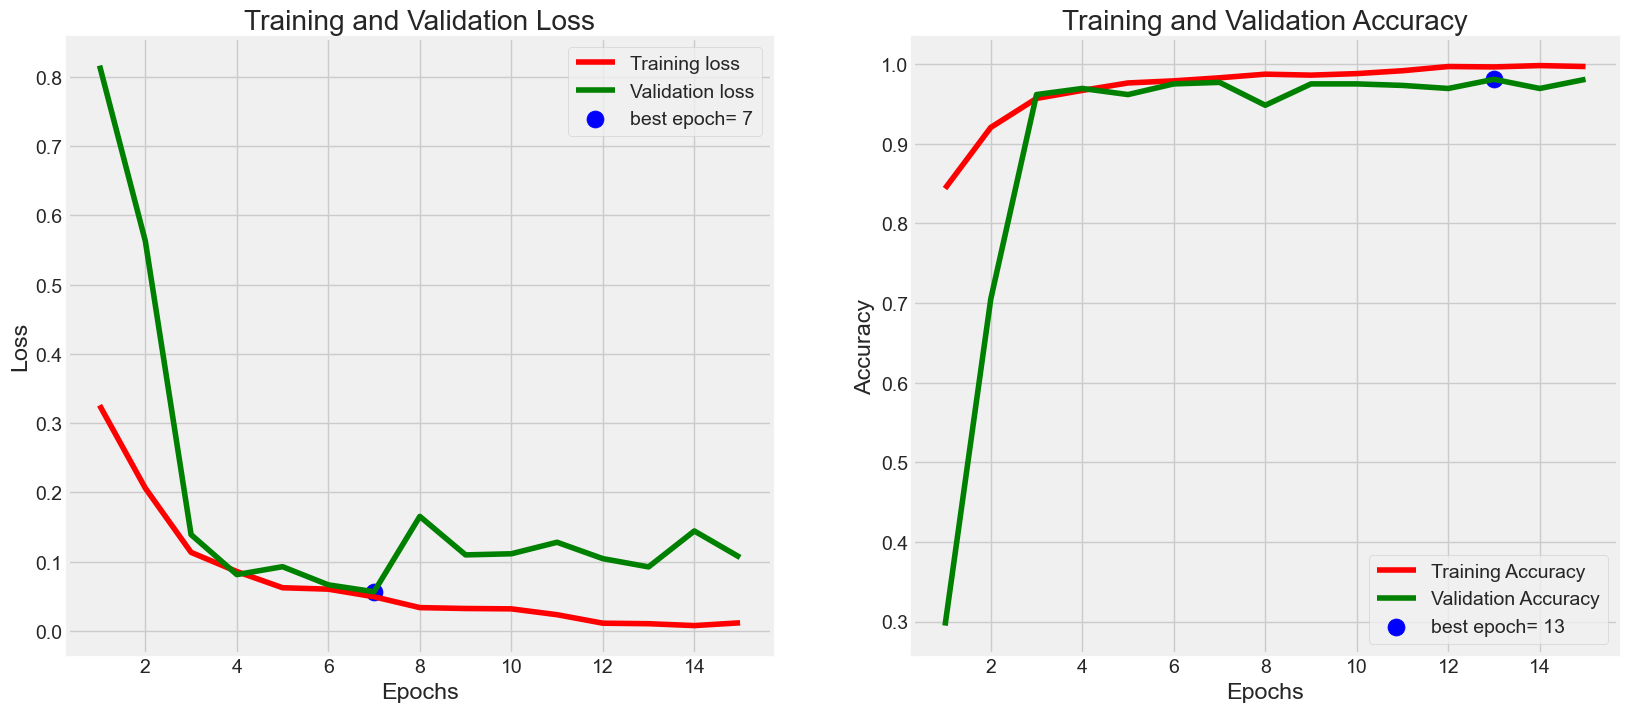

33/33 [==============================] - 5s 149ms/step - loss: 0.1051 - accuracy: 0.9789
Train Loss:  0.0034284894354641438
Train Accuracy:  0.9980824589729309
--------------------
Validation Loss:  0.10618718713521957
Validation Accuracy:  0.9808428883552551
--------------------
Test Loss:  0.10510194301605225
Test Accuracy:  0.9789271950721741


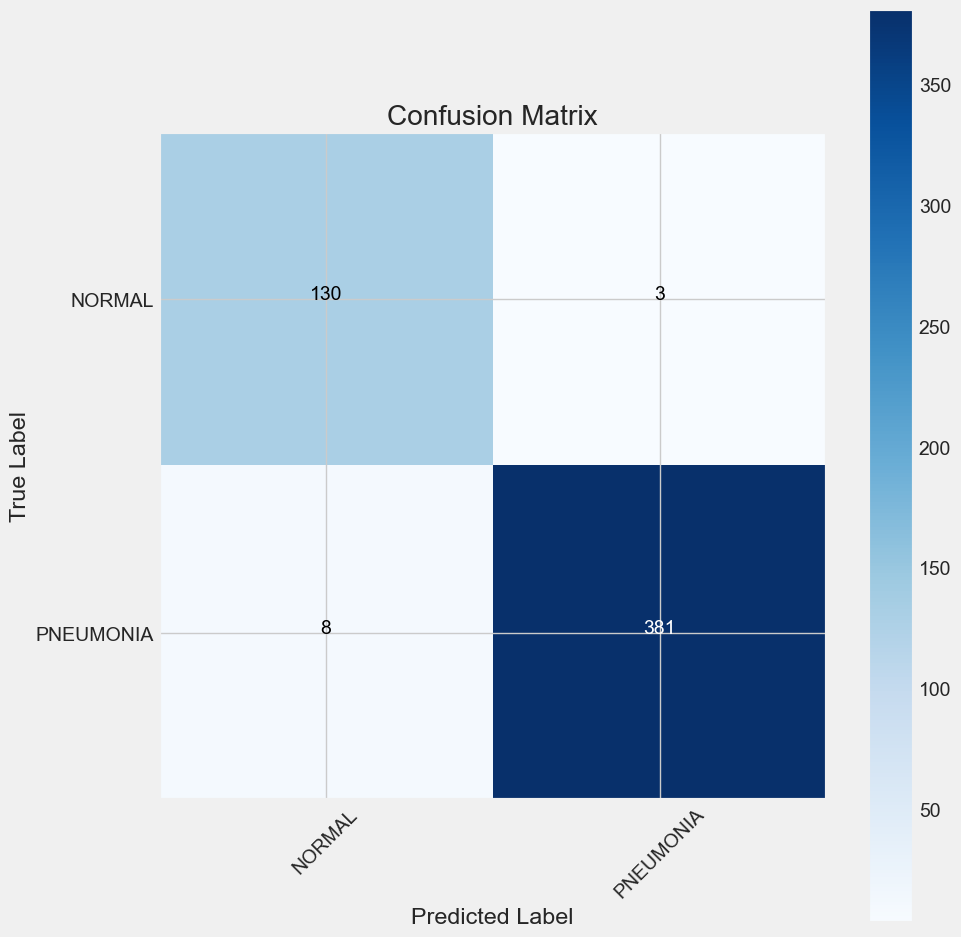

              precision    recall  f1-score   support

      NORMAL       0.94      0.98      0.96       133
   PNEUMONIA       0.99      0.98      0.99       389

    accuracy                           0.98       522
   macro avg       0.97      0.98      0.97       522
weighted avg       0.98      0.98      0.98       522



In [17]:
modelGraphs(history5)
modelEvaluationMetrix(model3)
modelConfustionMatrix(model3, test_gen)
modelClassificationReport(model3, test_gen)

In [18]:
trainDataPath = 'input/chest_xray/train_augmented'
trainDataframe = createDataframe(trainDataPath)
trainDataframe, dummy_df = train_test_split(trainDataframe, train_size=0.8, shuffle=True, random_state=42)
validationDataframe, testDataframe = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=42)

train_gen = ImageDataGenerator().flow_from_dataframe(
    trainDataframe,
    x_col='filepath', y_col= 'label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle= True,
    batch_size=batch_size
)

Found 6200 validated image filenames belonging to 2 classes.


In [19]:
valid_gen = ImageDataGenerator().flow_from_dataframe(
    validationDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',shuffle=True,
    batch_size=batch_size
)

test_gen = ImageDataGenerator().flow_from_dataframe(
    testDataframe,
    x_col='filepath', y_col='label',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 775 validated image filenames belonging to 2 classes.
Found 775 validated image filenames belonging to 2 classes.


In [20]:
history6 = model3.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle= False)

Epoch 1/15
388/388 [==============================] - 257s 663ms/step - loss: 0.0448 - accuracy: 0.9861 - val_loss: 0.0510 - val_accuracy: 0.9819
Epoch 2/15
388/388 [==============================] - 242s 623ms/step - loss: 0.0190 - accuracy: 0.9937 - val_loss: 0.0995 - val_accuracy: 0.9665
Epoch 3/15
388/388 [==============================] - 136s 352ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0198 - val_accuracy: 0.9935
Epoch 4/15
388/388 [==============================] - 136s 351ms/step - loss: 0.0091 - accuracy: 0.9966 - val_loss: 0.0520 - val_accuracy: 0.9845
Epoch 5/15
388/388 [==============================] - 137s 352ms/step - loss: 0.0117 - accuracy: 0.9971 - val_loss: 0.1642 - val_accuracy: 0.9703
Epoch 6/15
388/388 [==============================] - 136s 351ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.0255 - val_accuracy: 0.9923
Epoch 7/15
388/388 [==============================] - 206s 531ms/step - loss: 0.0097 - accuracy: 0.9968 - val_loss: 0.0289 -

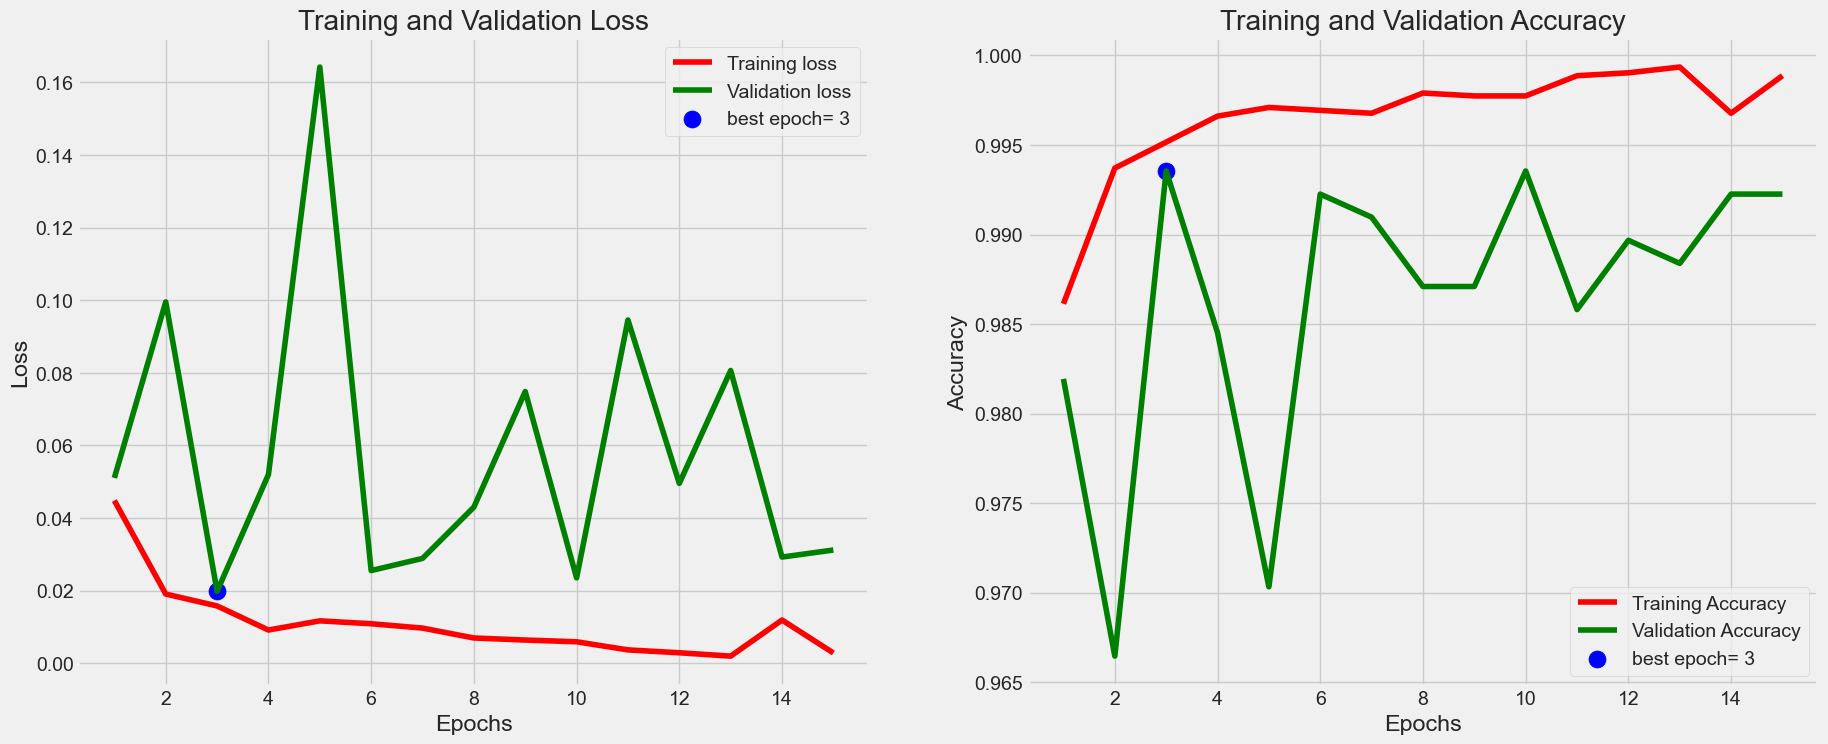

49/49 [==============================] - 6s 119ms/step - loss: 0.0201 - accuracy: 0.9961
Train Loss:  0.0001322875323239714
Train Accuracy:  1.0
--------------------
Validation Loss:  0.031177155673503876
Validation Accuracy:  0.9922580718994141
--------------------
Test Loss:  0.020116131752729416
Test Accuracy:  0.996129035949707


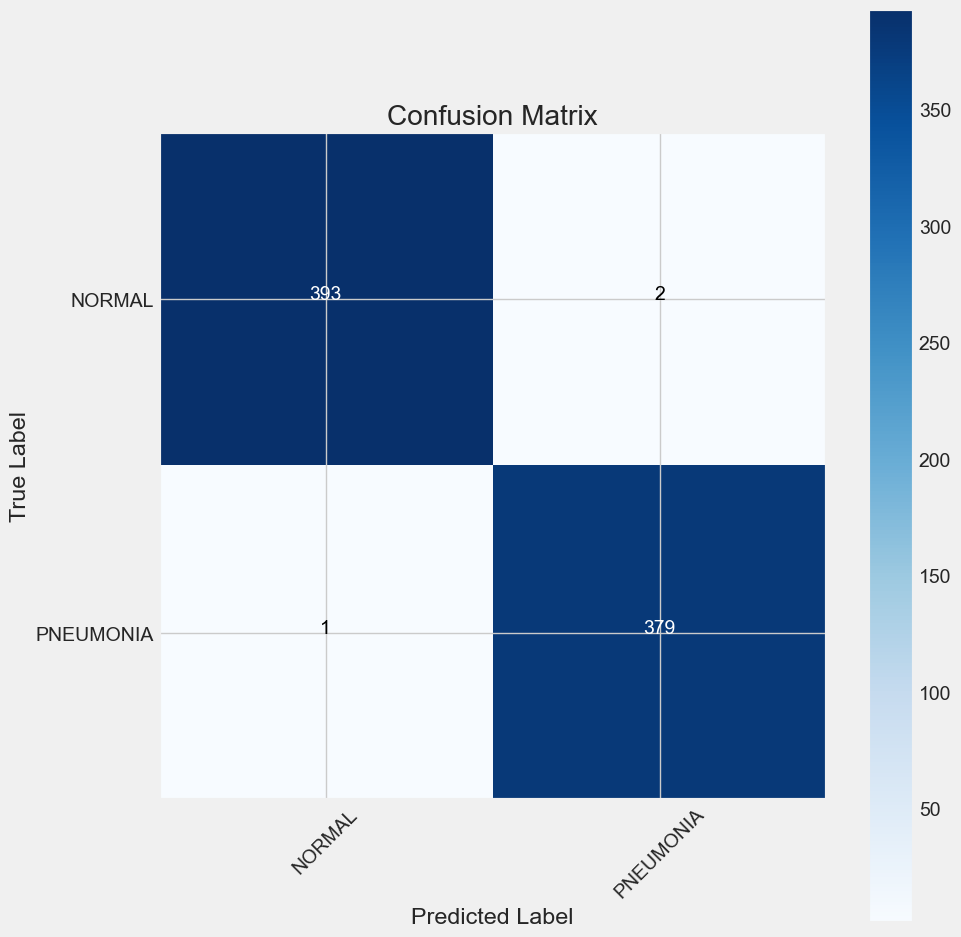

              precision    recall  f1-score   support

      NORMAL       1.00      0.99      1.00       395
   PNEUMONIA       0.99      1.00      1.00       380

    accuracy                           1.00       775
   macro avg       1.00      1.00      1.00       775
weighted avg       1.00      1.00      1.00       775



In [21]:
modelGraphs(history6)
modelEvaluationMetrix(model3)
modelConfustionMatrix(model3, test_gen)
modelClassificationReport(model3, test_gen)